In [1]:
###### notebook for generating river centerlines from river masks over braided rivers

In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sys
from pathlib import Path


# toolboxes
sys.path.append("../tools")
import procBraided as pc
import skeletonize_func as skel

# Computing slopes
from sklearn.linear_model import LinearRegression
from shapely.geometry import LineString
from skimage.filters import gaussian


In [ ]:
# Change to your local directories where necessary (datadir, wdir, odir, figdir, cldir)
# ------------------------------ STATICS ------------------------------

featureName = 'brahmaputra'
hemi='north'
datadir = r"D:\work\SWOTC\brahmaputra\PIXC" # Change to your local directory where data is stored
wdir = r"C:\Users\safr\Documents\github\braided_rivers\scripts" #wdir is current directory
odir = r"../odir/"
figdir = r"../figs/"
tile_figdir = r"../figs/258_112L/"
cldir = r"d:\work\SWORD\v16\brahmaputra\brahmaputra_full.shp"


isExist = os.path.exists(odir)
if not isExist:
    os.makedirs(odir)
    
tileID = '258_112L'

# manually set low flow and high flow months
LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

runNewCL = True # Set to True if you want to regenerate centerlines


In [3]:
# Transient functions

def plot_merged(cl_merged, maskdate,figdir):

    # Ensure GeoDataFrame is in a projected CRS for accurate placement
    if not cl_merged.crs.is_projected:
        print("Reprojecting to UTM for better plotting.")
        cl_merged = cl_merged.to_crs('EPSG:3857')  # Example of a projected CRS

    # Create a color map for branch IDs
    unique_ids = cl_merged['branch_id'].unique()
    num_branches = len(unique_ids)
    # Generate a repeating discrete color map using tab20 or a larger palette
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # tab20 has 20 colors
    color_map = {branch_id: colors[i % 20] for i, branch_id in enumerate(unique_ids)}

    # Plot the linestrings
    fig, ax = plt.subplots(figsize=(3, 6))
    for _, row in cl_merged.iterrows():
        color = color_map[row['branch_id']]
        ax.plot(*row.geometry.xy, color=color, linewidth=2, label=f"Branch {row['branch_id']}")

    # Remove duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    # Add text labels for each branch ID
    # for _, row in cl_merged.iterrows():
    #     if row['branch_id']%5 == 0:
    #         x, y = row.geometry.xy[0][len(row.geometry.xy[0]) // 2], row.geometry.xy[1][len(row.geometry.xy[1]) // 2]
    #         ax.text(x, y, str(row['branch_id']), fontsize=12, ha='right', va='center', color='black')

    # Set plot properties
    ax.set_title(str(maskdate)[0:2]+'-'+str(maskdate)[2:4],fontsize=15)
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(figdir+'/'+maskdate+'_generated_centerlines.png')
    plt.show()

    #Plot the linestrings in blue
    fig, ax = plt.subplots(figsize=(3, 6))
    for _, row in cl_merged.iterrows():
        color = 'blue'
        ax.plot(*row.geometry.xy, color=color, linewidth=2, label=f"Branch {row['branch_id']}")

    # Remove duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    # Add text labels for each branch ID
    # for _, row in cl_merged.iterrows():
    #     if row['branch_id']%5 == 0:
    #         x, y = row.geometry.xy[0][len(row.geometry.xy[0]) // 2], row.geometry.xy[1][len(row.geometry.xy[1]) // 2]
    #         ax.text(x, y, str(row['branch_id']), fontsize=12, ha='right', va='center', color='black')

    # Set plot properties
    ax.set_title(str(maskdate)[0:2]+'-'+str(maskdate)[2:4],fontsize=15)
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(figdir+'/'+maskdate+'_generated_centerlines_unlabeled.png')
    plt.show()




<Axes: >

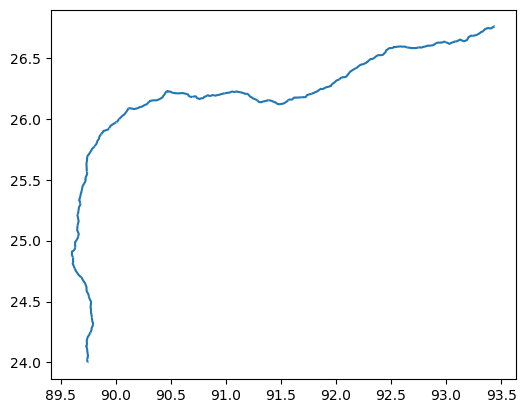

In [4]:
# ---------------------------- Load in SWORD centerline ----------------------------
cl = gpd.read_file(cldir)
cl = cl.to_crs('EPSG:4326')
sword_cl_gdf, sword_cline, sword_cl_points = pc.sort_SWORD_cl(cl,showPlots=False) # Output is gdf
sword_cl_gdf.plot()


In [ ]:
# ---------------------------- SWOT PIXC files to process ----------------------------
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*258_112L*") # Need to download 1 year of data for this tile! 
pixc_filenames

# file list
glob_path = Path(r"D:\work\SWOTC\brahmaputra\PIXC")
filenames = list(glob_path.glob("SWOT*.nc"))


# ---------------------------- Monthly S2 NDWI water masks - These are accesesd within the function pc.getNearestMaskDate -------------------------
watermask_path  = Path(r"D:\work\water_masks\brahmaputra\258_112L")
watermask_filenames = list(watermask_path.glob("S2_WaterMask_NDWI_****.tif"))
watermask_filenames

[WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0324.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_1223.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_1024.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0424.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_1123.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0924.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0124.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0923.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0524.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0224.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMask_NDWI_0623.tif'),
 WindowsPath('D:/work/water_masks/brahmaputra/258_112L/S2_WaterMa

In [ ]:
#Choose just a few files...
pixc_filenames = list(glob_path.glob("SWOT*20240203*.nc"))
pixc_filenames


[WindowsPath('D:/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc')]

Runnning braided river analysis for: 20240203
Closest mask date: 0224
Proceed with operation skeleton...
...........Running get skeleton algorithm...........
...........Running branch pruning algorithm...........
Running prune branches...
Running prune branches...
Pruning algorithm applied 2 times!
...........Running skeleton labeling algorithm...........
...........Running centerline extraction from skeleton algorithm...........
Branch No. 27, less than 2! Skeletonize...
Reprojecting to UTM for better plotting.


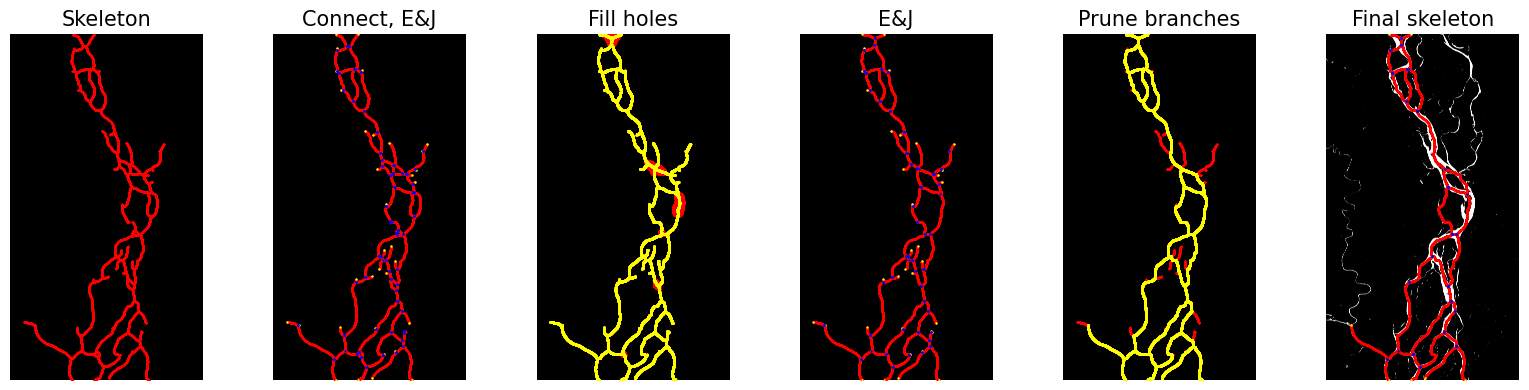

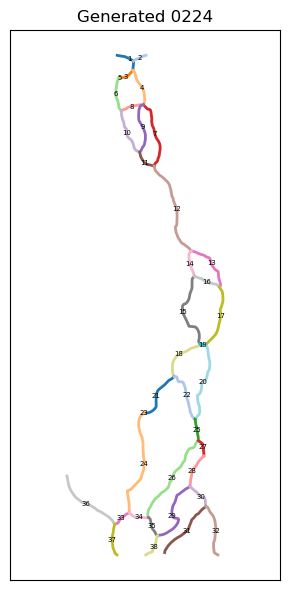

SUCCESSFUL SKELETON! Saving files...


In [7]:
# ------------------------------ DYNAMICS ------------------------------


for filename in pixc_filenames:

    pixcdate = os.path.basename(filename)[29:37]
    print('Runnning braided river analysis for:',str(pixcdate))

    maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)

    # Get season
    if int(maskdate[0:2]) in LFmonths:
        dilate = 10
        gauss = 20
    else:
        dilate = 10
        gauss = 30

    # Proceed with operation skeleton
    print('Proceed with operation skeleton...')
    # Create folder to save files...

    isExist = os.path.exists(odir+tileID)
    if not isExist:
        os.makedirs(odir+tileID)
        
    isExist = os.path.exists(tile_figdir)
    if not isExist:
        os.makedirs(tile_figdir)

    # FIRST Check if a centerline has already been created for this mask....
    if os.path.exists(odir+tileID+'/'+maskdate+'_generated_cl.geojson') and runNewCL == False:
        print('Mask centerline already processed!')
        cl_merged = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
    else:
        water_mask = skel.get_watermask(water_mask_tiff)
        skeleton = skel.get_skeleton(water_mask,pixcdate,tile_figdir,dilate,gauss,savePlot=True)
        pruned_skeleton = skel.get_pruned_skeleton(skeleton, water_mask, pixcdate,tile_figdir,distance_threshold=100,max_hole_size=300,prunethresh=600) # distance thresh for connecting pixels
        labeled_skeleton = skel.get_labeled_skeleton(pruned_skeleton,pixcdate,tile_figdir,savePlot=True)
        gen_cl = skel.extract_cl_from_skeleton(labeled_skeleton,water_mask_tiff)
        cl_merged = skel.merge_short_centerlines(gen_cl,hemi)
        skel.plot_merged(cl_merged,maskdate,tile_figdir)
        
        print('SUCCESSFUL SKELETON! Saving files...')
        cl_merged.to_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')




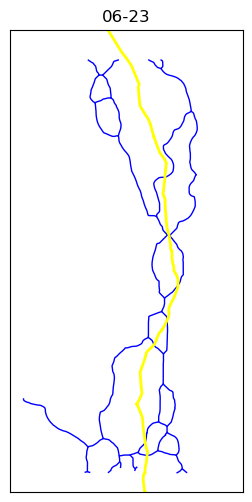

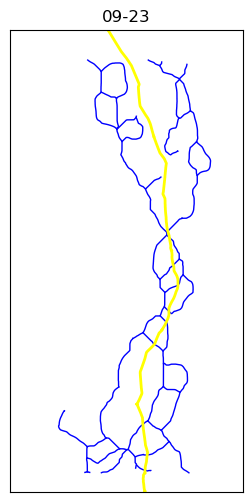

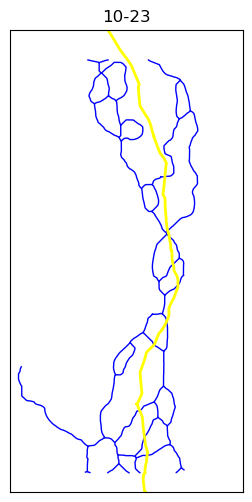

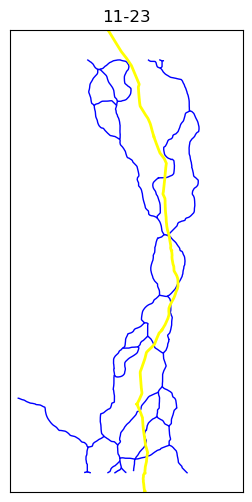

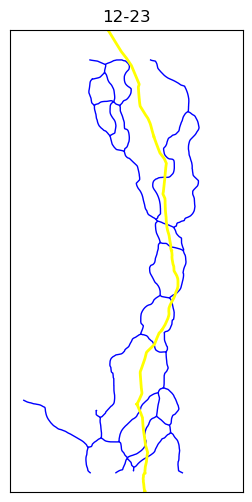

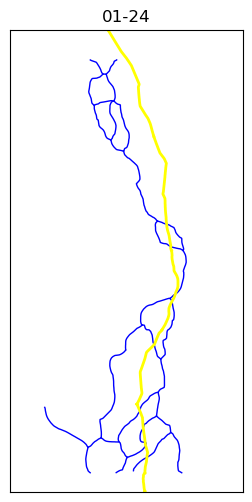

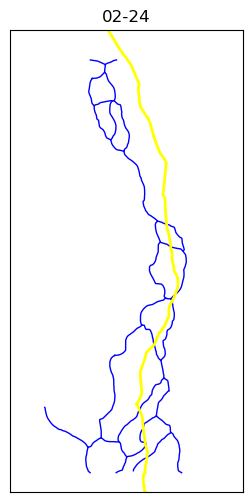

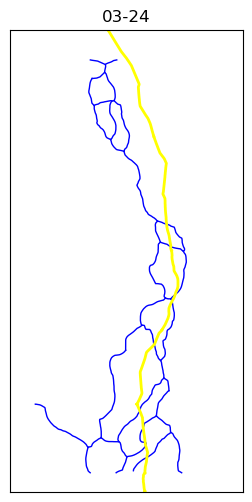

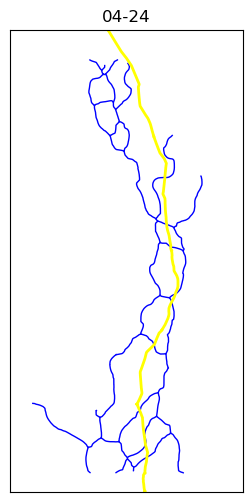

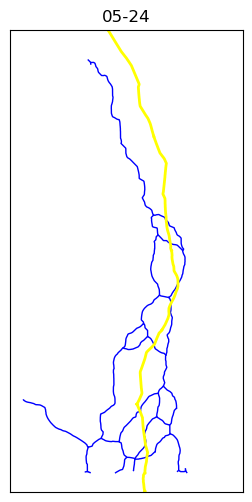

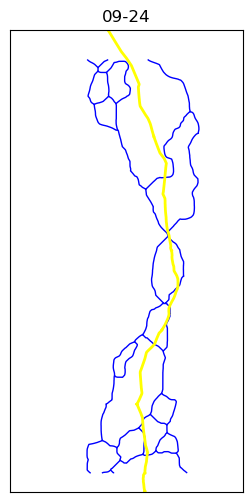

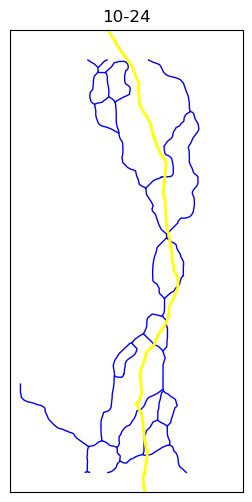

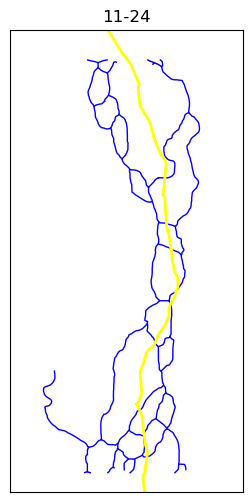

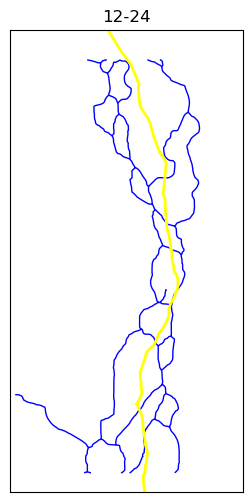

In [ ]:
# ------------------------------ plotting generated centerline and watermask images (side by side and one on top of another) ------------------------------

# Get list of all mask dates
maskdates = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/"+tileID+"/S2_WaterMask_NDWI_****.tif")
maskdates = [os.path.basename(mask)[18:22] for mask in maskdates]
maskdates_list = [ date for date in maskdates if date.isnumeric() ]
sorted_dates = sorted(maskdates_list, key=lambda x: (int(x[2:]), int(x[:2])))

# Find mask date
for maskdate in sorted_dates:

    water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")
    

    water_mask_tiff = water_mask_tiff[0]

    #water_mask = skel.get_watermask(water_mask_tiff)

    if not glob.glob(odir+tileID+'/'+maskdate+'_generated_cl.geojson'):
        # Check if a centerline was created for this mask
        continue

    cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
    cl_gen = cl_gen.to_crs('EPSG:4326') 
    sword_cl_gdf = sword_cl_gdf.to_crs('EPSG:4326')

    isExist = os.path.exists(figdir+'/'+tileID+'/')
    if not isExist:
        os.makedirs(figdir+'/'+tileID+'/')

    # Plot generated CL
    fig, ax = plt.subplots(figsize=(3, 6))

    for _, row in cl_gen.iterrows():
        ax.plot(*row.geometry.xy, color='blue', linewidth=1)

    # PLOT SWORD CL on top
    for _, row in sword_cl_gdf.iterrows():
        ax.plot(*row.geometry.xy, color='yellow', linewidth=2)

   # ax.plot(sword_cline.xy, color='yellow', linewidth=2)
    # Set plot properties
    ax.set_title(str(maskdate[0:2]+'-'+str(maskdate[2:4])))
    ax.axis("equal")
    # Remove x and y tick marks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim(89.575,89.855)
    ax.set_ylim(24.0,24.7)
    plt.savefig(figdir+'/'+tileID+'/'+maskdate+'_generated_cl.png')

    plt.show()

    # # Plot watermask
    # water_mask = skel.get_watermask(water_mask_tiff)
    # fig, ax = plt.subplots(figsize=(3, 6))
    # ax.imshow(water_mask, cmap=plt.cm.gray)
    # ax.axis('off')
    # ax.set_title(str(maskdate[0:2]+'-'+str(maskdate[2:4])))
    # plt.savefig(figdir+'/'+tileID+'/'+maskdate+'_mask.png')
    # plt.tight_layout()
    # plt.show()

    # # PLOT mask and centerline
    # fig, ax = plt.subplots(figsize=(3, 6))
    # coords_df = cl_gen.get_coordinates()
    # cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    # ax.imshow(water_mask, cmap=plt.cm.gray)
    # ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.05)
    # ax.axis('off')
    # ax.set_title(str(maskdate[0:2]+'-'+str(maskdate[2:4])))

    # plt.tight_layout()
    # plt.savefig(figdir+'/'+tileID+'/'+maskdate+'_generated_cl_wMask.png')
    # plt.show()

